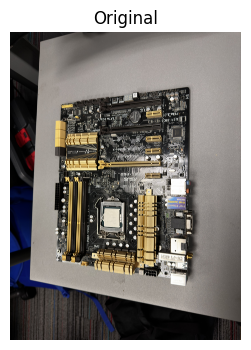

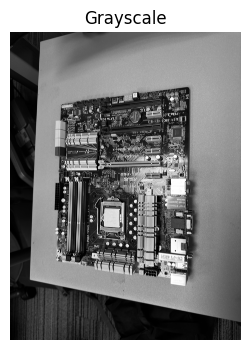

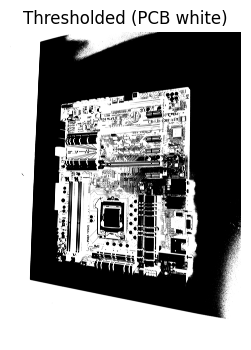

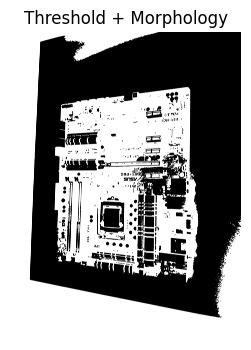

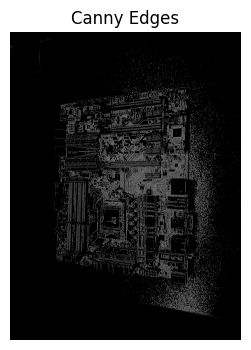

Selected PCB contour area: 8019831.0


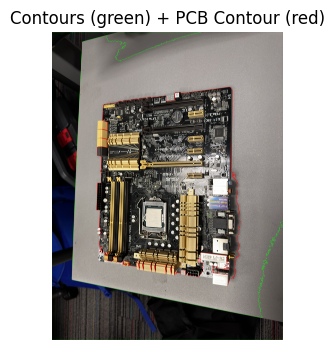

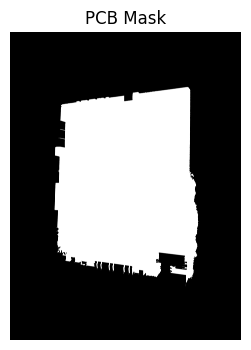

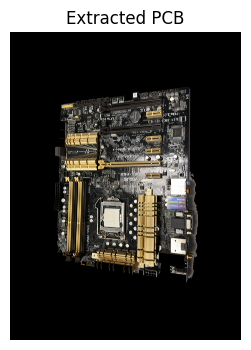

True

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_image(title: str, img, gray: bool = False, size=(4, 4)) -> None:
    """Utility to display an image with a title."""
    plt.figure(figsize=size)
    if gray:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

# Load image
img_path = "/content/PCB_Data/Project 3 Data/motherboard_image.JPEG"
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(f"Could not load image at: {img_path}")

show_image("Original", img)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
show_image("Grayscale", gray, gray=True)

# Thresholding (segment PCB from background)
_, thresh = cv2.threshold(
    gray,
    0,
    255,
    cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU,
)
show_image("Thresholded (PCB white)", thresh, gray=True)

# Morphological
kernel = np.ones((5, 5), np.uint8)
thresh_clean = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
show_image("Threshold + Morphology", thresh_clean, gray=True)

# Edge detection (Canny)
edges = cv2.Canny(gray, 80, 200)
show_image("Canny Edges", edges, gray=True)

# Contour detection
contours, _ = cv2.findContours(
    thresh_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

min_area = 0.01 * gray.shape[0] * gray.shape[1]
large_contours = [c for c in contours if cv2.contourArea(c) > min_area]

if not large_contours:
    large_contours = contours

pcb_contour = max(large_contours, key=cv2.contourArea)
print("Selected PCB contour area:", cv2.contourArea(pcb_contour))

# Visualize contours
contour_img = img.copy()
cv2.drawContours(contour_img, large_contours, -1, (0, 255, 0), 2)
cv2.drawContours(contour_img, [pcb_contour], -1, (0, 0, 255), 4)
show_image("Contours (green) + PCB Contour (red)", contour_img)

# Binary mask from PCB contour
mask = np.zeros_like(gray, dtype=np.uint8)
cv2.drawContours(mask, [pcb_contour], -1, 255, thickness=-1)
show_image("PCB Mask", mask, gray=True)

# Extract PCB using mask
pcb_extracted = cv2.bitwise_and(img, img, mask=mask)
show_image("Extracted PCB", pcb_extracted)

cv2.imwrite("step1_threshold.png", thresh)
cv2.imwrite("step1_thresh_clean.png", thresh_clean)
cv2.imwrite("step1_edges.png", edges)
cv2.imwrite("step1_contours.png", contour_img)
cv2.imwrite("step1_mask.png", mask)
cv2.imwrite("step1_pcb_extracted.png", pcb_extracted)






In [1]:
# STEP 2: YOLOv11 Training
# Install Ultralytics (YOLOv11)
!pip install -q ultralytics

from ultralytics import YOLO
import os

# YOLO dataset configuration
data_yaml_path = "/content/PCB_Data/dataset/data/data.yaml"
if not os.path.exists(data_yaml_path):
    raise FileNotFoundError(f"data.yaml not found at: {data_yaml_path}")

print("Using dataset configuration at:", data_yaml_path)

# Load pretrained YOLOv11
model = YOLO("yolo11n.pt")

# Train the model
results = model.train(
    data=data_yaml_path,
    epochs=60,
    batch=2,
    imgsz=928,
    workers=1,
    name="pcb_yolo11n_lowmem"
)

# Location of trained weights
weights_dir = "runs/detect/pcb_yolo11n_lowmem/weights"
print("\nTraining complete.")
print("Weights saved in:", weights_dir)

!ls "{weights_dir}"


CUDA available: True
Using data.yaml at: /content/PCB_Data/dataset/data/data.yaml
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=2, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/PCB_Data/dataset/data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=928, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=pcb_yolo11n_lowmem, nbs=64, nms=False, opset=

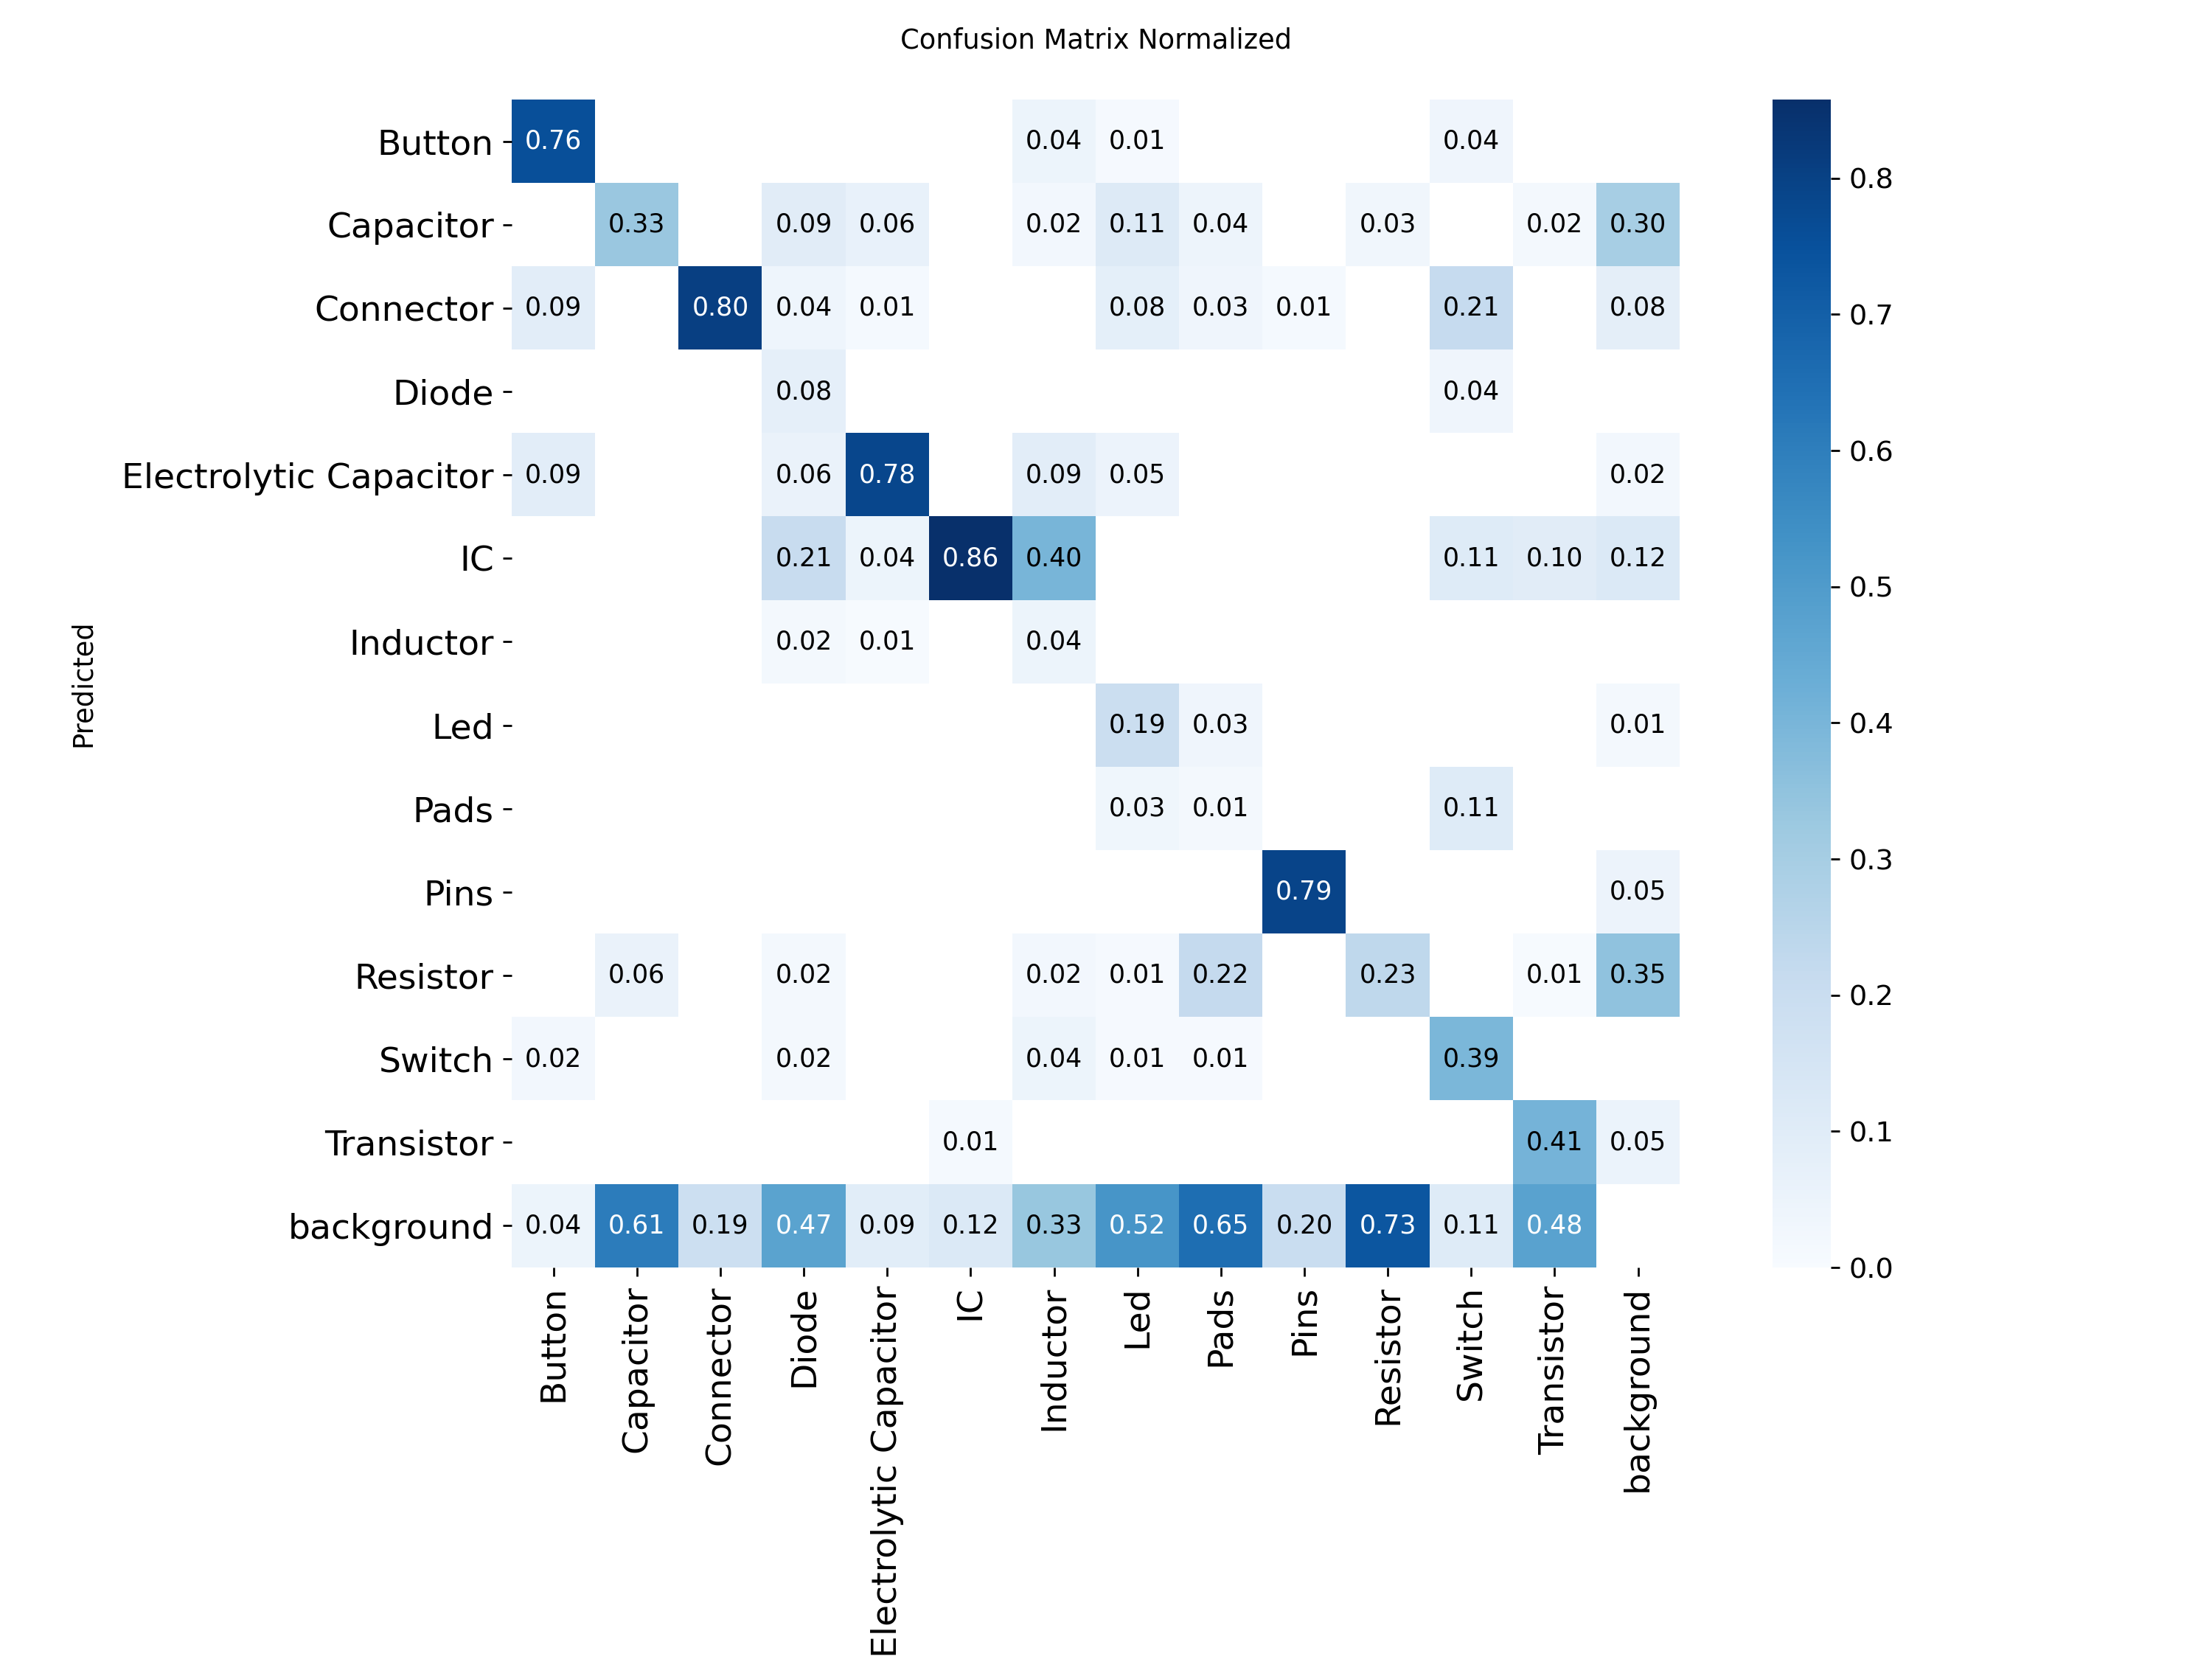

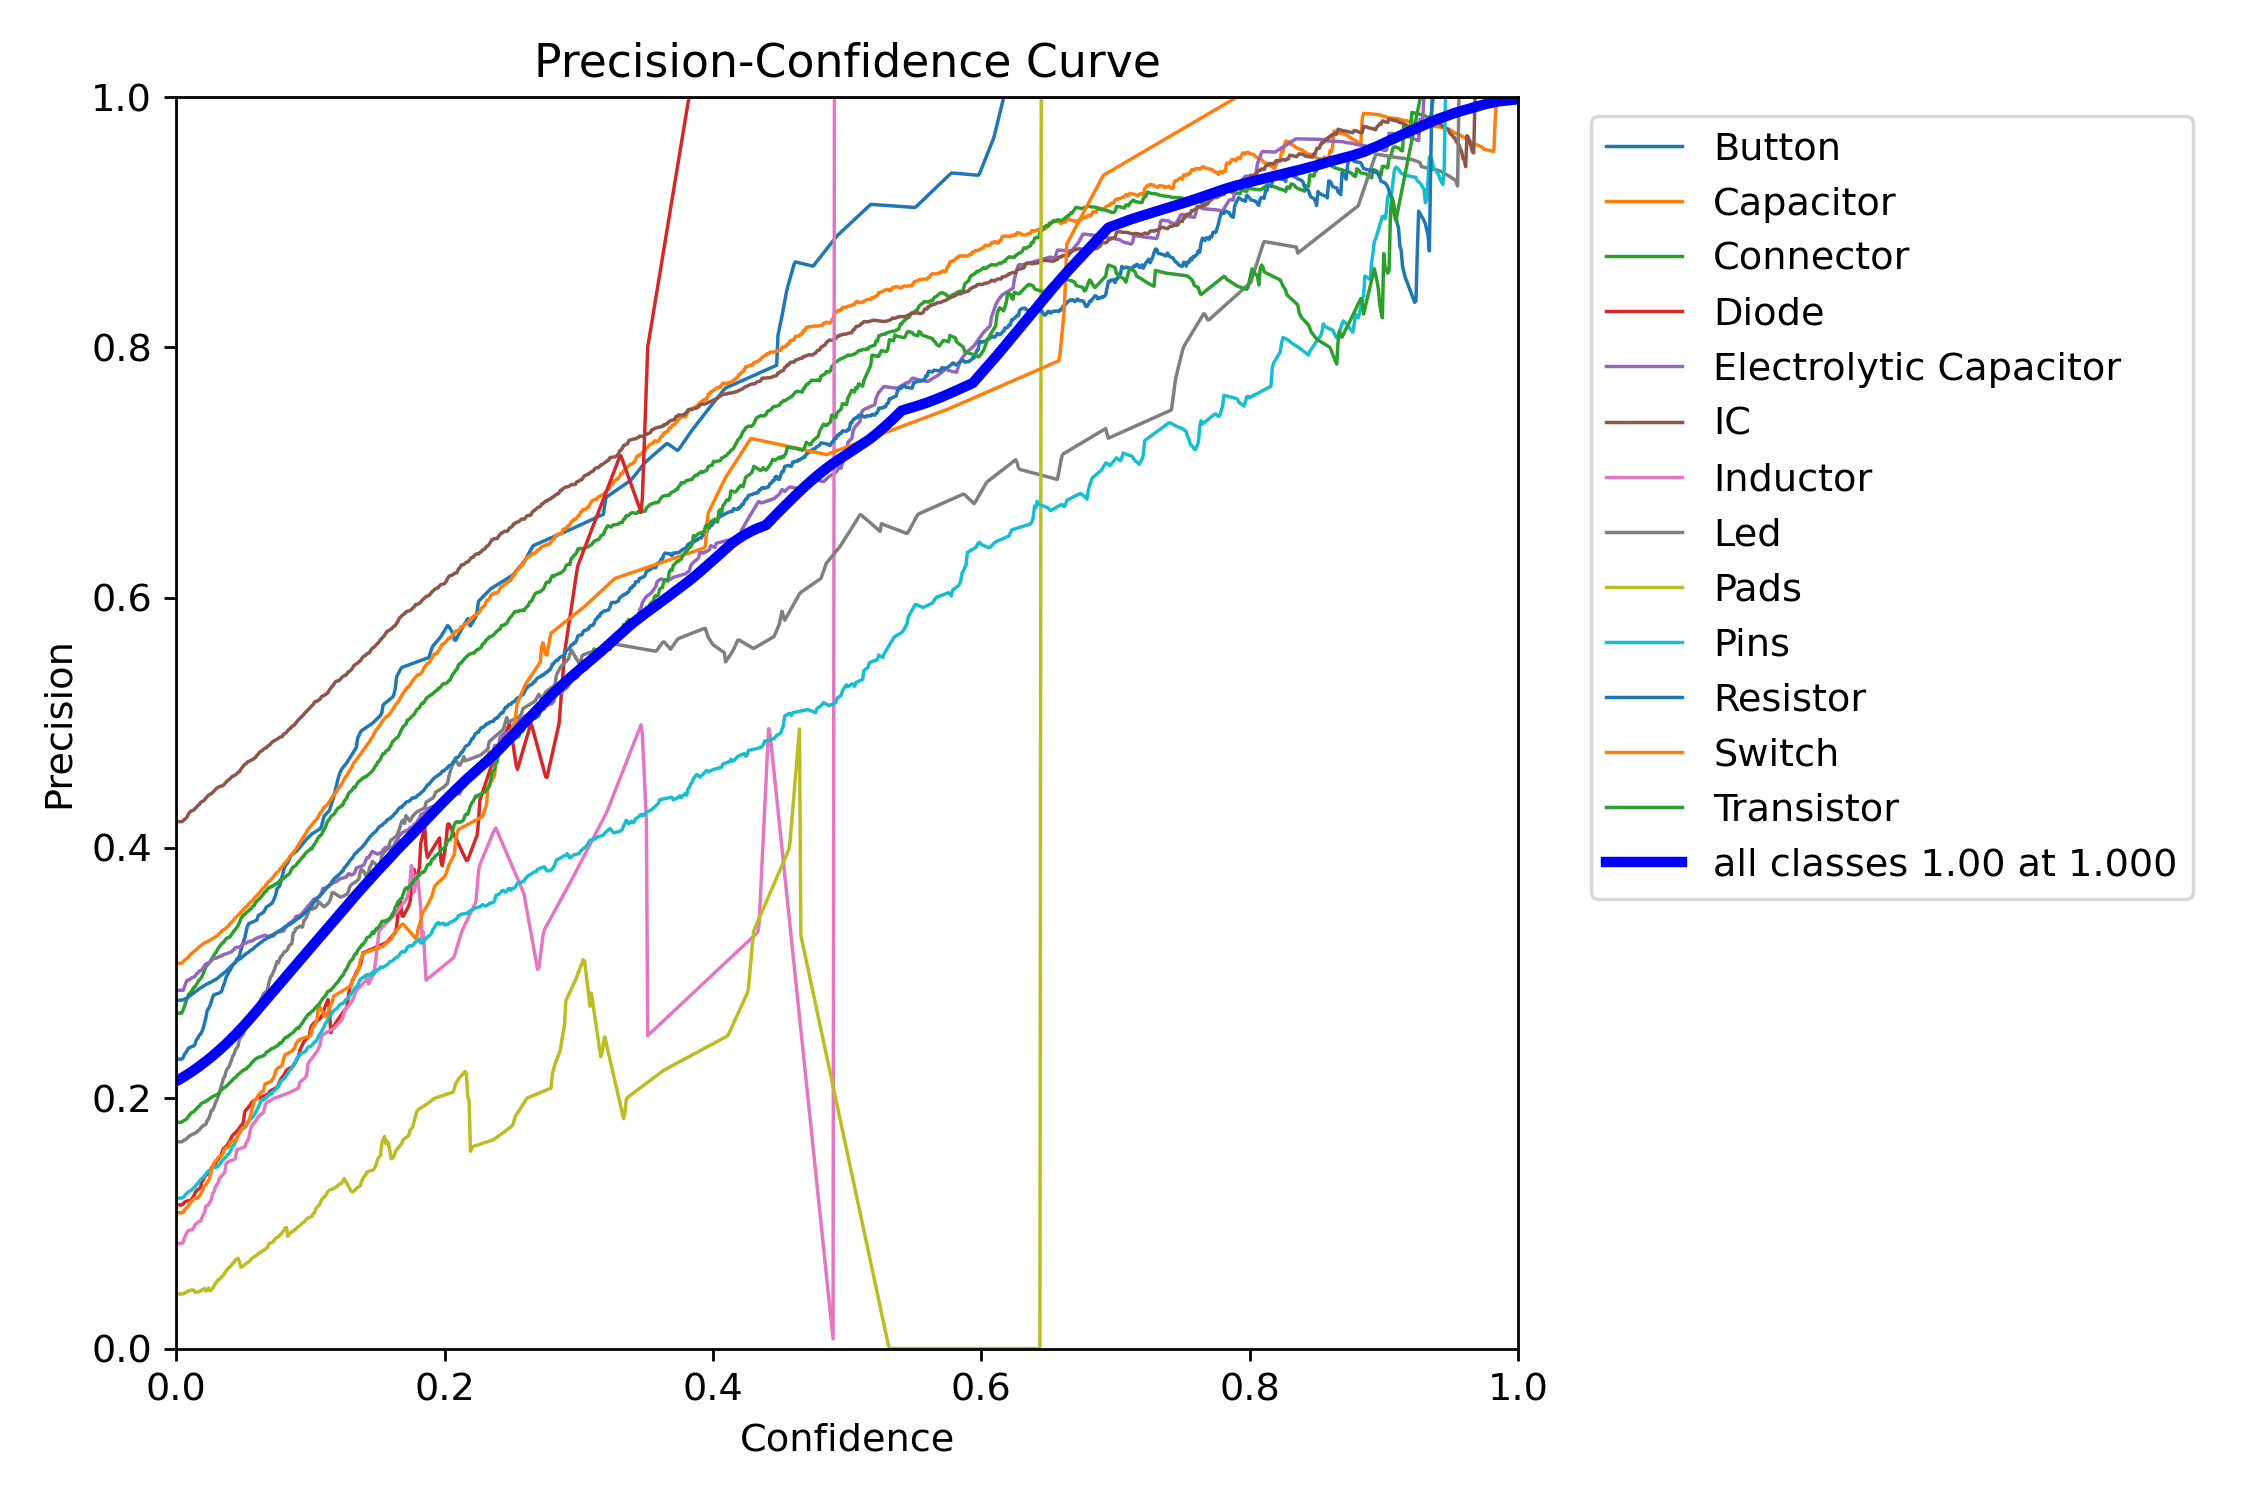

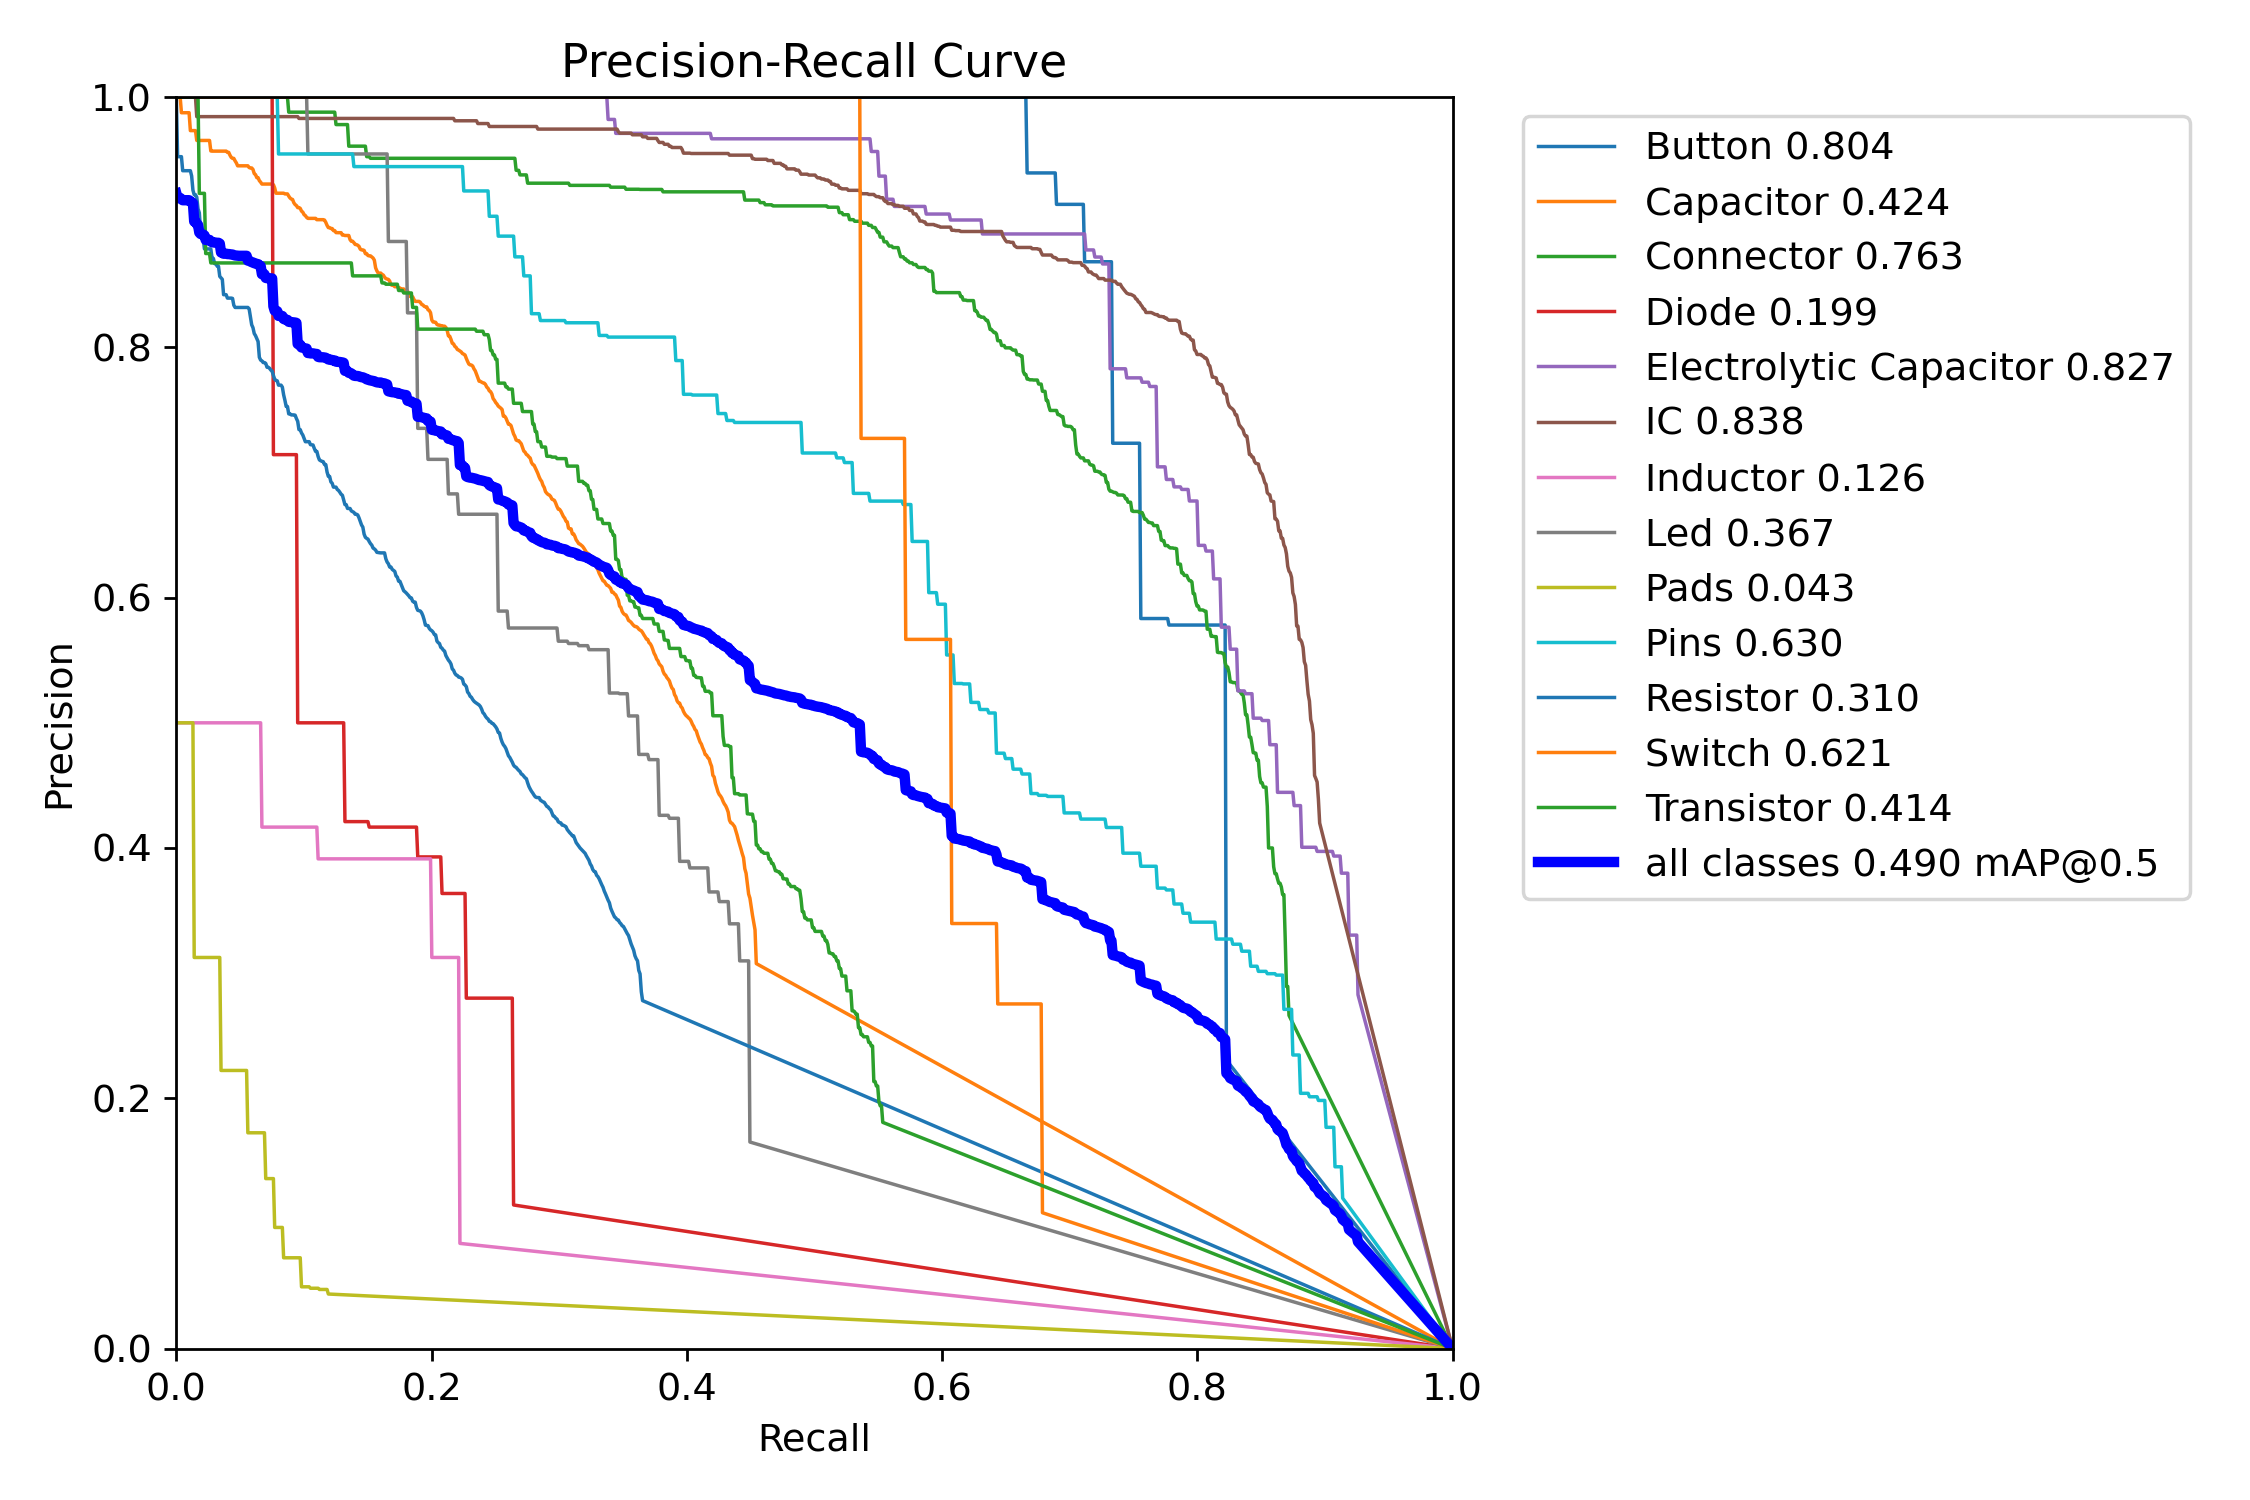

In [10]:
from IPython.display import Image, display

display(Image(filename="/content/runs/detect/pcb_yolo11n_lowmem/confusion_matrix_normalized.png"))

display(Image(filename="/content/runs/detect/pcb_yolo11n_lowmem/BoxP_curve.png"))

display(Image(filename="/content/runs/detect/pcb_yolo11n_lowmem/BoxPR_curve.png"))



image 1/3 /content/PCB_Data/dataset/data/evaluation/ardmega.jpg: 864x960 10 Capacitors, 13 Connectors, 3 Electrolytic Capacitors, 7 ICs, 22 Resistors, 13.2ms
image 2/3 /content/PCB_Data/dataset/data/evaluation/arduno.jpg: 672x960 19 Capacitors, 8 Connectors, 2 Electrolytic Capacitors, 13 ICs, 3 Leds, 6 Resistors, 1 Transistor, 10.8ms
image 3/3 /content/PCB_Data/dataset/data/evaluation/rasppi.jpg: 640x960 18 Capacitors, 10 Connectors, 1 Diode, 1 Electrolytic Capacitor, 14 ICs, 20 Resistors, 2 Switchs, 14.7ms
Speed: 5.3ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 960)
Results saved to /content/runs/detect/pcb_eval_lowmem3


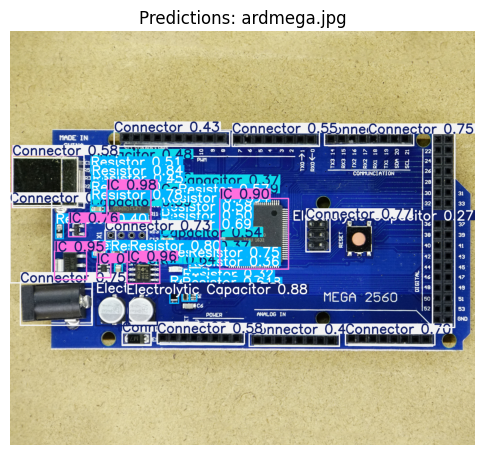

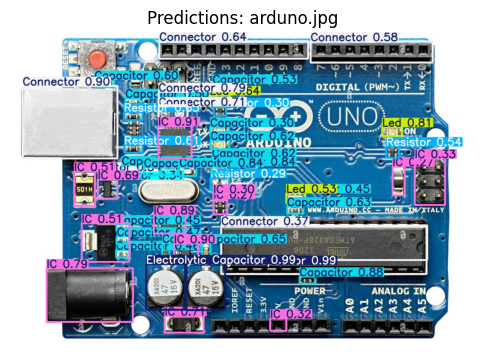

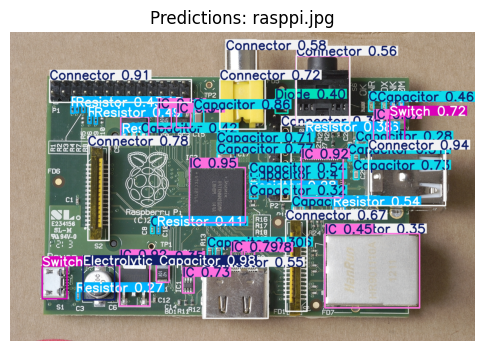

In [12]:
# STEP 3: YOLOv11 Evaluation
from ultralytics import YOLO
import os, glob
import matplotlib.pyplot as plt
import cv2

weights_path = "/content/runs/detect/pcb_yolo11n_lowmem/weights/best.pt"
eval_dir     = "/content/PCB_Data/dataset/data/evaluation"
out_name     = "pcb_eval_lowmem"

model = YOLO(weights_path)

# Run prediction
results = model.predict(
    source=eval_dir,
    imgsz=960,
    conf=0.25,
    save=True,
    project="runs/detect",
    name=out_name
)

pred_dir = f"runs/detect/{out_name}"
image_paths = sorted(glob.glob(pred_dir + "/*.jpg") +
                     glob.glob(pred_dir + "/*.png"))

for path in image_paths:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Predictions: {os.path.basename(path)}")
    plt.axis("off")
    plt.show()
